distinguish several types of clustering algorithms, including the following:

1 Connectivity: This clustering is based on distance connectivity, like hier- archical clustering. For an example in finance, see López de Prado (2016).

2 Centroids: These algorithms perform a vector quantization, like k-means. For an example in finance, see López de Prado and Lewis (2018).

3 Distribution: Clusters are formed using statistical distributions, e.g., a mixture of Gaussians.

4 Density: These algorithms search for connected dense regions in the data space. Examples include DBSCAN and OPTICS.

5 Subspace: Clusters are modeled on two dimensions, features and observa- tions. An example is biclustering (also known as coclustering). For instance, they can help identify similarities in subsets of instruments and time periods simultaneously.



In [5]:
import os
import sys
nb_path = os.path.split(os.getcwd())[0]
if nb_path not in sys.path:
    sys.path.append(nb_path)

In [6]:
import CovMatrix
corr0,eVal0,eVec0 = CovMatrix.init_para()


/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [88]:
#SNIPPET 4.1 BASE CLUSTERING
import numpy as np,pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples 
#--------------------------------------------------- 
def clusterKMeansBase(corr0,maxNumClusters=10,n_init=10):
    x,silh=((1-corr0.fillna(0))/2.)**.5,pd.Series()# observations matrix 
    for init in range(n_init):
        for i in range(2,maxNumClusters+1): 
            kmeans_=KMeans(n_clusters=i,n_jobs=1,n_init=1) 
            kmeans_=kmeans_.fit(x) 
            silh_=silhouette_samples(x,kmeans_.labels_) 
            stat=(silh_.mean()/silh_.std(),silh.mean()/silh.std())
            if np.isnan(stat[1]) or stat[0]>stat[1]: 
                silh,kmeans=silh_,kmeans_
    newIdx=np.argsort(kmeans.labels_) 
    corr1=corr0.iloc[newIdx] # reorder rows

    corr1=corr1.iloc[:,newIdx] # reorder columns 
    clstrs={i:corr0.columns[np.where(kmeans.labels_==i)[0]].tolist() \
            for i in np.unique(kmeans.labels_) } # cluster members 
    silh=pd.Series(silh,index=x.index)
    return corr1,clstrs,silh

In [89]:
corr1,clstrs,silh = clusterKMeansBase(pd.DataFrame(corr0))

In [90]:
#a new (reduced) observations matrix out of the elements that compose the K1 clusters, and rerun the base clustering algorithm on that reduced correlation matrix. Doing so will return a, possibly new, clustering for those elements in K1. To check its efficacy, we compare the average cluster quality before and after reclustering those elements in K1. If the average cluster quality improves, we return the accepted clustering from the base clustering concate- nated with the new clustering for the redone nodes.

#SNIPPET 4.2 TOP-LEVEL OF CLUSTERING
from sklearn.metrics import silhouette_samples 
#--------------------------------------------------- 
def makeNewOutputs(corr0,clstrs,clstrs2):
    clstrsNew={}
    for i in clstrs.keys():
        clstrsNew[len(clstrsNew.keys())]=list(clstrs[i]) 
    for i in clstrs2.keys():
        clstrsNew[len(clstrsNew.keys())]=list(clstrs2[i]) 
    newIdx=[j for i in clstrsNew for j in clstrsNew[i]] 
    corrNew=corr0.loc[newIdx,newIdx] 
    x=((1-corr0.fillna(0))/2.)**.5 
    kmeans_labels=np.zeros(len(x.columns))
    for i in clstrsNew.keys(): 
        idxs=[x.index.get_loc(k) for k in clstrsNew[i]] 
        kmeans_labels[idxs]=i
    silhNew=pd.Series(silhouette_samples(x,kmeans_labels),index=x.index)
    return corrNew,clstrsNew,silhNew 

#--------------------------------------------------- 
def clusterKMeansTop(corr0,maxNumClusters=None,n_init=3): # for real stock data, n_init start from 10 ; for simulated data, n_init=3 would speed up the process
    if maxNumClusters==None:
        maxNumClusters=corr0.shape[1]-1 
    corr1,clstrs,silh=clusterKMeansBase(corr0,maxNumClusters= \
                                        min(maxNumClusters,corr0.shape[1]-1),n_init=n_init) 
    clusterTstats={i:np.mean(silh[clstrs[i]])/ \
                   np.std(silh[clstrs[i]]) for i in clstrs.keys()}
    tStatMean=sum(clusterTstats.values())/len(clusterTstats) 
    redoClusters=[i for i in clusterTstats.keys() if \
                  clusterTstats[i]<tStatMean] 
    if len(redoClusters)<=1:
        return corr1,clstrs,silh 
    else:
        keysRedo=[j for i in redoClusters for j in clstrs[i]] 
        corrTmp=corr0.loc[keysRedo,keysRedo] 
        tStatMean=np.mean([clusterTstats[i] for i in redoClusters]) 
        corr2,clstrs2,silh2=clusterKMeansTop(corrTmp, \
                                             maxNumClusters=min(maxNumClusters, \
                                                                corrTmp.shape[1]-1),n_init=n_init)
    # Make new outputs, if necessary 
    corrNew,clstrsNew,silhNew=makeNewOutputs(corr0, \
                                             {i:clstrs[i] for i in clstrs.keys() if i not in redoClusters}, \
                                             clstrs2) 
    newTstatMean=np.mean([np.mean(silhNew[clstrsNew[i]])/ \
                          np.std(silhNew[clstrsNew[i]]) for i in clstrsNew.keys()]) 
    if newTstatMean<=tStatMean:
        return corr1,clstrs,silh 
    else:
        return corrNew,clstrsNew,silhNew

In [64]:
#SNIPPET 4.3 RANDOM BLOCK CORRELATION MATRIX CREATION
import numpy as np,pandas as pd
from scipy.linalg import block_diag
from sklearn.utils import check_random_state 
#--------------------------------------------------- 
def getCovSub(nObs,nCols,sigma,random_state=None):
    # Sub correl matrix 
    rng=check_random_state(random_state)
    if nCols==1:
        return np.ones((1,1)) 
    ar0=rng.normal(size=(nObs,1)) 
    ar0=np.repeat(ar0,nCols,axis=1) 
    ar0+=rng.normal(scale=sigma,size=ar0.shape) 
    ar0=np.cov(ar0,rowvar=False)
    return ar0
#--------------------------------------------------- 
def getRndBlockCov(nCols,nBlocks,minBlockSize=1,sigma=1.,
                   random_state=None):
    # Generate a block random correlation matrix 
    rng=check_random_state(random_state) 
    parts=rng.choice(range(1,nCols-(minBlockSize-1)*nBlocks), \
                     nBlocks-1,replace=False)
    parts.sort() 
    parts=np.append(parts,nCols-(minBlockSize-1)*nBlocks) 
    parts=np.append(parts[0],np.diff(parts))-1+minBlockSize # random number of the cols in each block
    cov=None
    for nCols_ in parts:
        cov_=getCovSub(int(max(nCols_*(nCols_+1)/2.,100)), \
                       nCols_,sigma,random_state=rng)
        if cov is None:
            cov=cov_.copy()
        else:
            cov=block_diag(cov,cov_) 
    return cov
#--------------------------------------------------- 
def randomBlockCorr(nCols,nBlocks,random_state=None,
                    minBlockSize=1):
    # Form block corr 
    rng=check_random_state(random_state)
    cov0=getRndBlockCov(nCols,nBlocks,minBlockSize=minBlockSize,sigma=.5,random_state=rng)
    cov1=getRndBlockCov(nCols,1,minBlockSize=minBlockSize, sigma=1.,random_state=rng) # add noise
    cov0+=cov1 
    corr0=CovMatrix.cov2corr(cov0) 
    corr0=pd.DataFrame(corr0) 
    return corr0

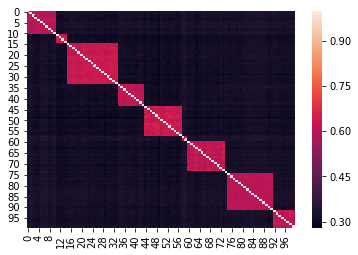

In [84]:
# simulated a cov matraix with blocks
import seaborn as sns
corr_blk_simu = randomBlockCorr(100,10)
sns.heatmap(corr_blk_simu)

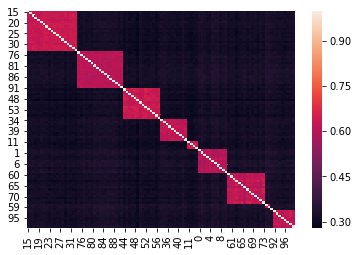

In [92]:
# clustered using clusterKMeansTop
sns.heatmap(clusterKMeansTop(corr_blk_simu)[0])